In [185]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn import functional as F
import torch.optim as optim
import tensorboard
import matplotlib.pyplot as plt
import matplotlib

In [186]:
dataset = torch.tensor(np.load('../splits/dataset.npy'))

In [187]:
dataset_norm = torch.tensor(np.load('../splits/dataset_normalized.npy'))

In [188]:
X = dataset_norm[:,:11,:,:,:]

In [189]:
y = dataset_norm[:,11:,:,:,:]

In [190]:
y_un = dataset[:,11:,:,:,:]

In [191]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(
            combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width,
                            device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width,
                            device=self.conv.weight.device))


class EncoderDecoderConvLSTM(nn.Module):

    def __init__(self, nf, in_chan, out_chan):
        super(EncoderDecoderConvLSTM, self).__init__()

        self.encoder_1_convlstm = ConvLSTMCell(input_dim=in_chan,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.encoder_2_convlstm = ConvLSTMCell(input_dim=nf,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.decoder_1_convlstm = ConvLSTMCell(input_dim=nf,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.decoder_2_convlstm = ConvLSTMCell(input_dim=nf,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.decoder_CNN = nn.Conv3d(in_channels=nf,
                                     out_channels=out_chan,
                                     kernel_size=(1, 3, 3),
                                     padding=(0, 1, 1))

    def autoencoder(self, x, past_steps, future_steps, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4):
        outputs = []

        for t in range(past_steps):
            h_t, c_t = self.encoder_1_convlstm(input_tensor=x[:, t, :, :],
                                              cur_state=[h_t,c_t])
            h_t2, c_t2 = self.encoder_2_convlstm(input_tensor=h_t,
                                                cur_state=[h_t2, c_t2])

        encoder_vector = h_t2

        for t in range(future_steps):
            h_t3, c_t3 = self.decoder_1_convlstm(input_tensor=encoder_vector,
                                                cur_state=[h_t3, c_t3])
            h_t4, c_t4 = self.decoder_2_convlstm(input_tensor=h_t3,
                                                cur_state=[h_t4, c_t4])
            encoder_vector = h_t4
            outputs.append(h_t4)

        outputs = torch.stack(outputs, 1)
        outputs = outputs.permute(0, 2, 1, 3, 4)
        outputs = self.decoder_CNN(outputs)
        outputs = outputs.permute(0, 2, 1, 3, 4)

        return outputs

    def forward(self, x, future_steps=30, hidden_state=None):
        b, past_steps, _, h, w = x.size()

        h_t, c_t = self.encoder_1_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t2, c_t2 = self.encoder_2_convlstm.init_hidden(batch_size=b, image_size=(h,w))
        h_t3, c_t3 = self.decoder_1_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t4, c_t4 = self.decoder_2_convlstm.init_hidden(batch_size=b, image_size=(h, w))

        outputs = self.autoencoder(x, past_steps, future_steps, h_t, c_t, h_t2, c_t2,
                                  h_t3, c_t3, h_t4, c_t4)

        return outputs

In [192]:
model = EncoderDecoderConvLSTM(nf=24, in_chan=8, out_chan=8)

In [193]:
model.load_state_dict(torch.load('../saved_models/lr_0.0005/epoch_1500.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [194]:
test_len = int(len(X) * 0.2)

In [195]:
the_range = list(range(len(X) - test_len, len(X)))

In [196]:
np.random.seed(42)

In [197]:
sample_indices = np.random.choice(the_range, size=20, replace=False)

In [198]:
sample_indices

array([809, 760, 782, 706, 745, 680, 752, 702, 751, 795, 670, 735, 666,
       717, 675, 681, 794, 755, 749, 667])

In [199]:
sample = X[sample_indices,:,:,:,:]

In [200]:
y_pred = model(sample).detach().numpy()

In [201]:
y_pred.shape

(20, 30, 8, 10, 20)

In [202]:
y_true = y[sample_indices,:,:,:,:].numpy()

In [203]:
y_true.shape

(20, 30, 8, 10, 20)

In [204]:
for_mask = y_un[sample_indices,:,:,:,:]

In [205]:
y_pred = np.ma.masked_where(for_mask.isnan(), y_pred)

In [206]:
y_true = np.ma.masked_where(for_mask.isnan(), y_true)

In [207]:
cmap = plt.get_cmap('Blues')

In [208]:
cmap.set_bad(color='green')

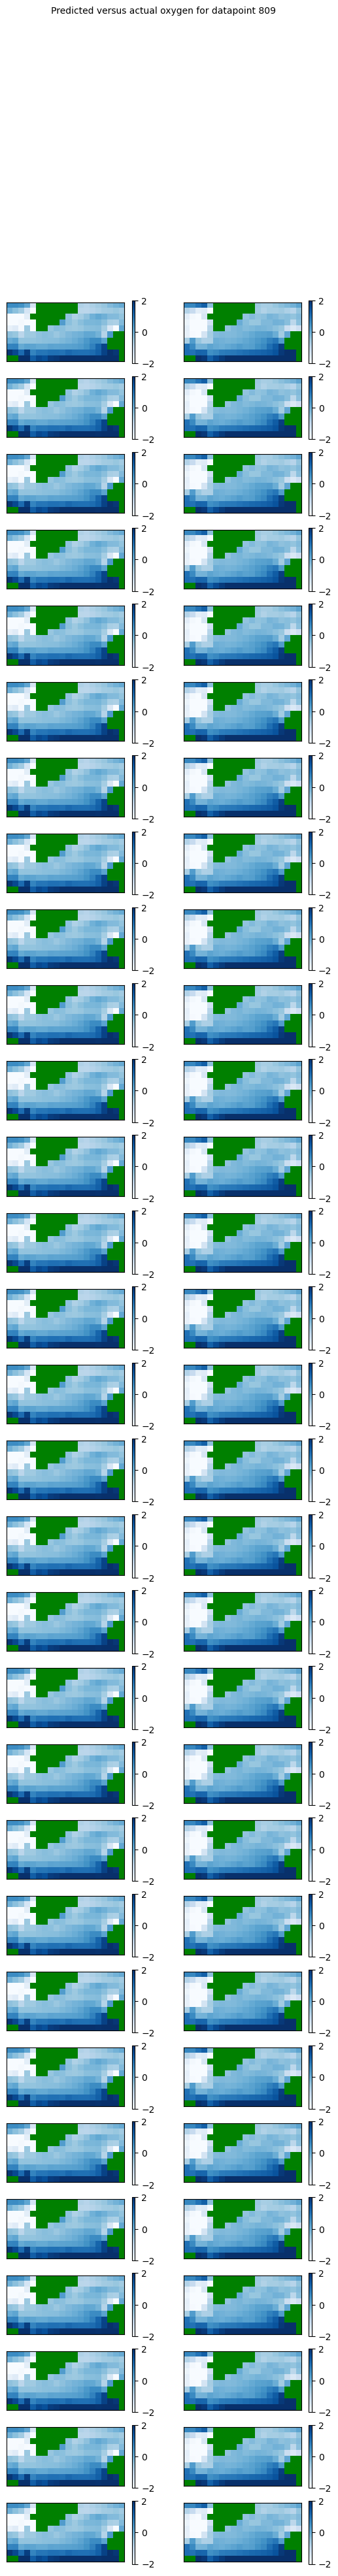

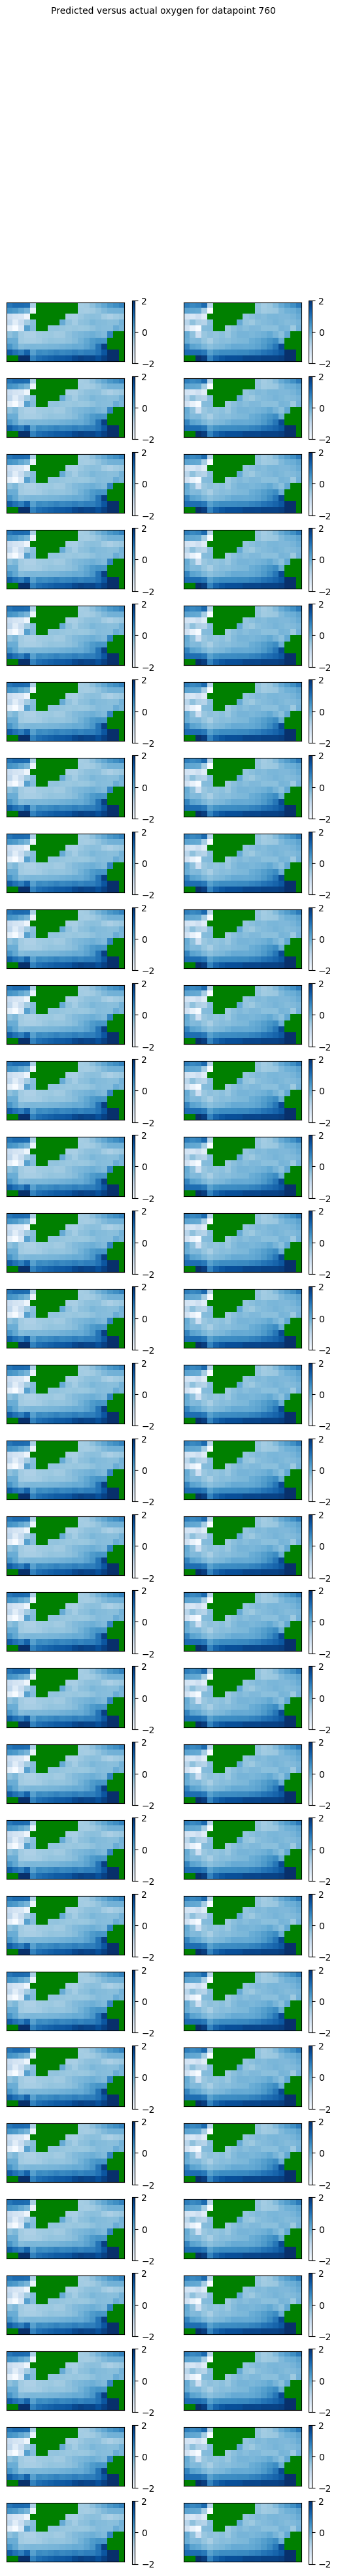

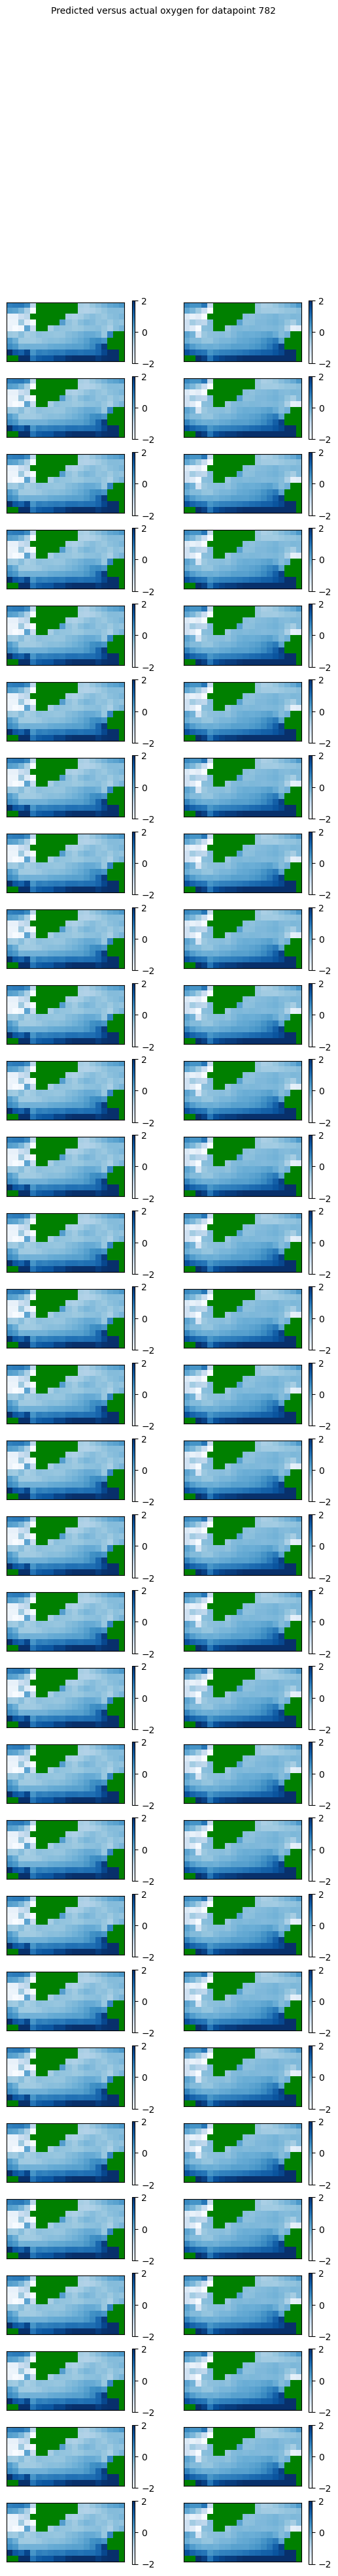

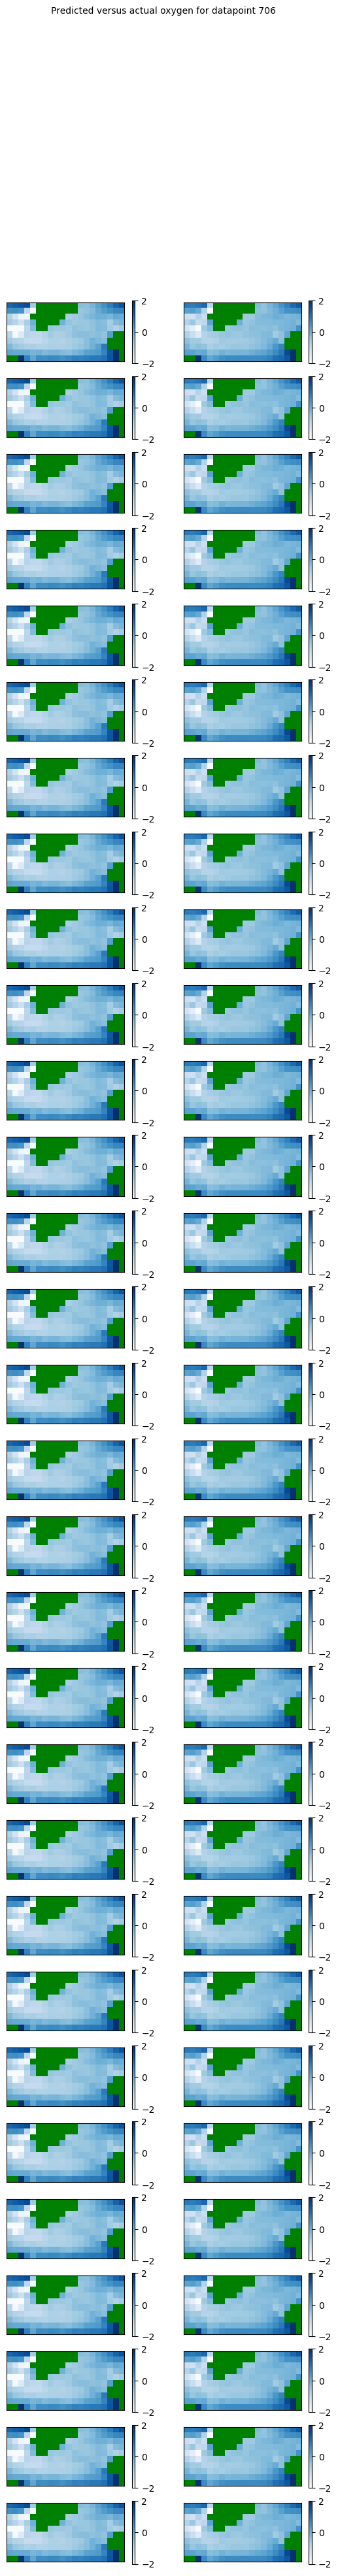

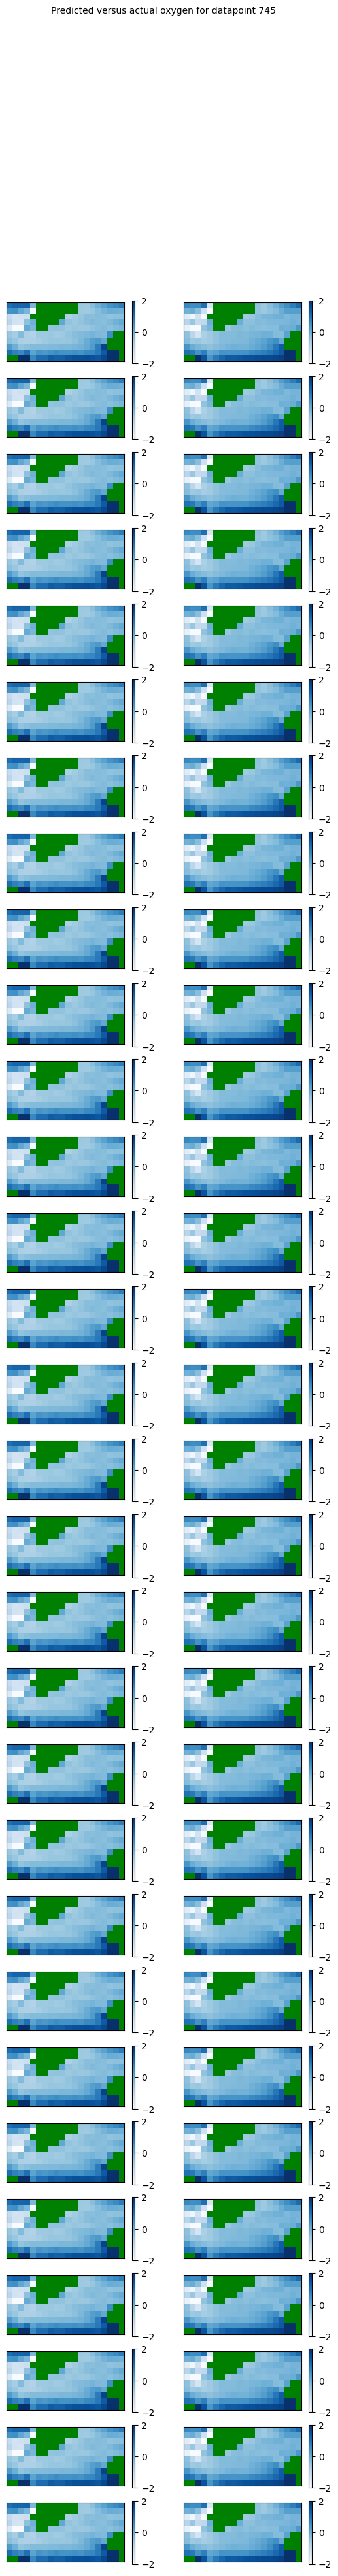

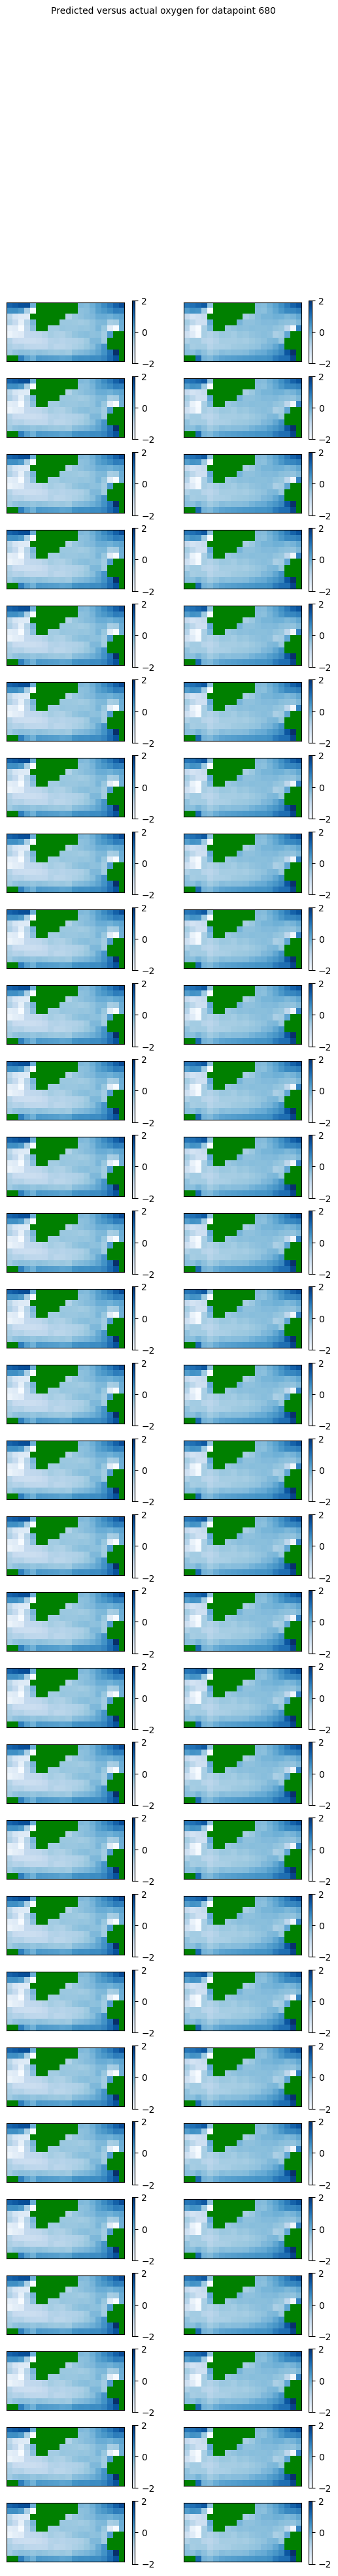

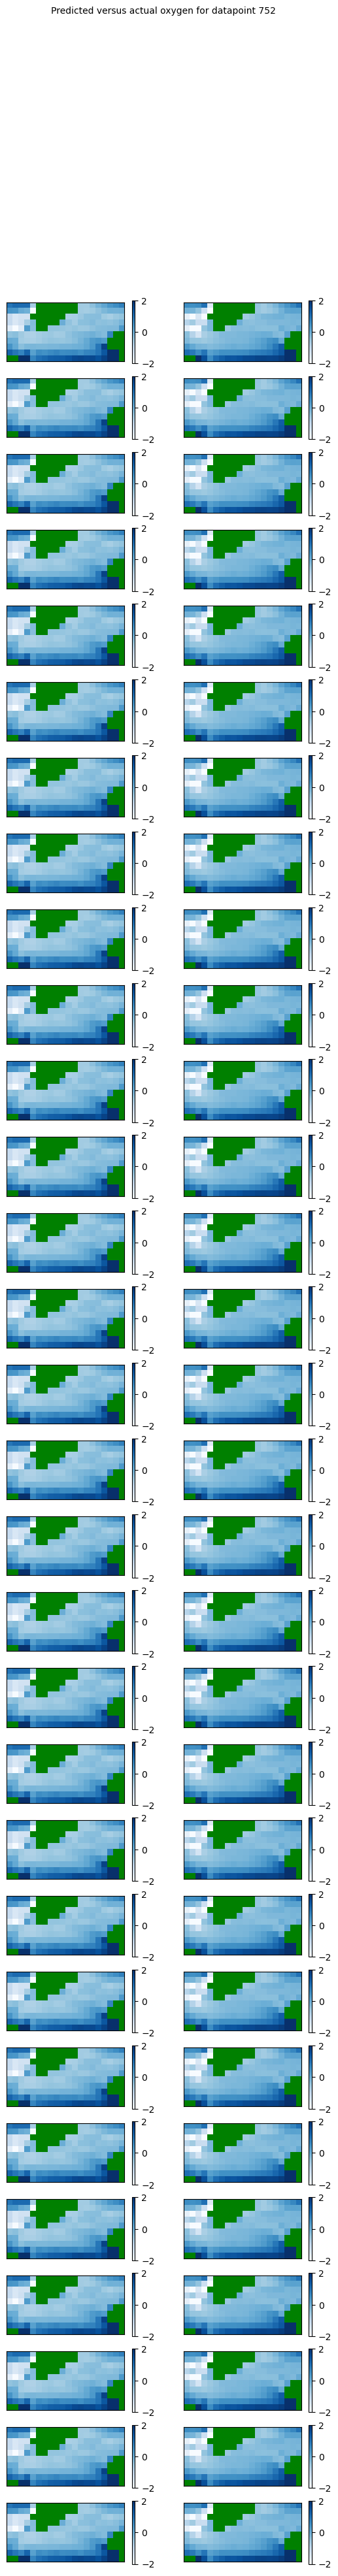

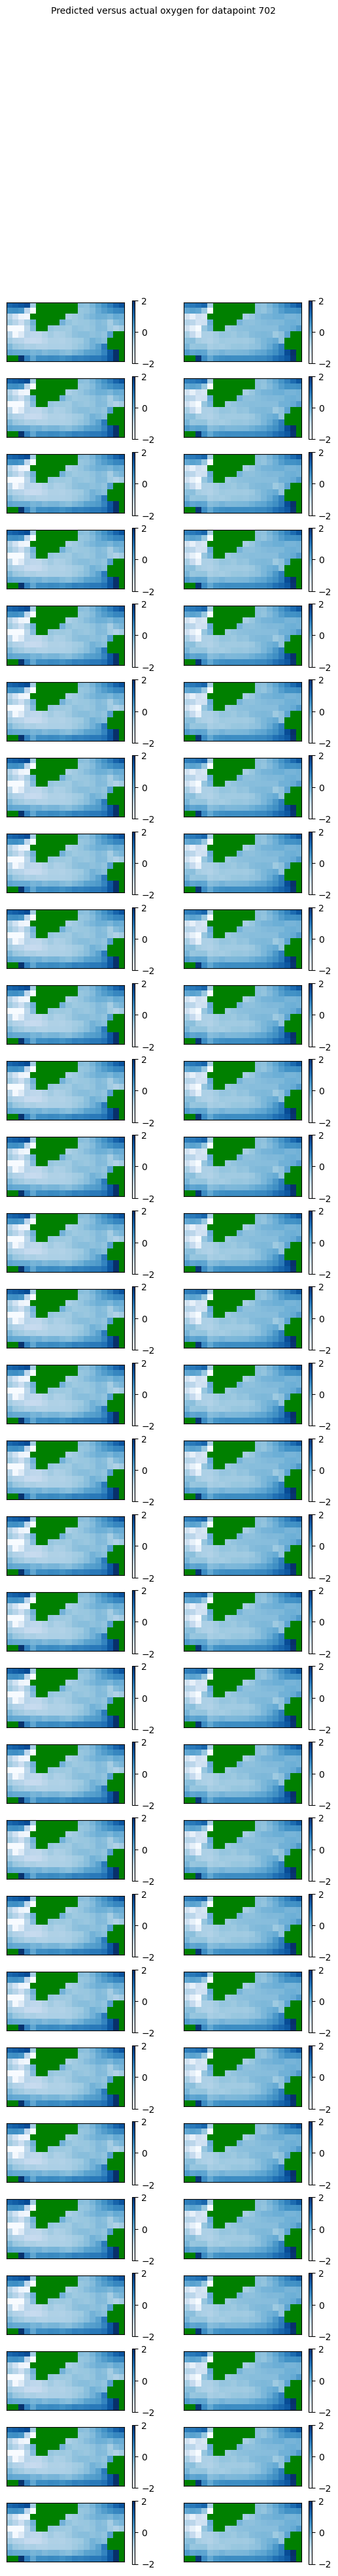

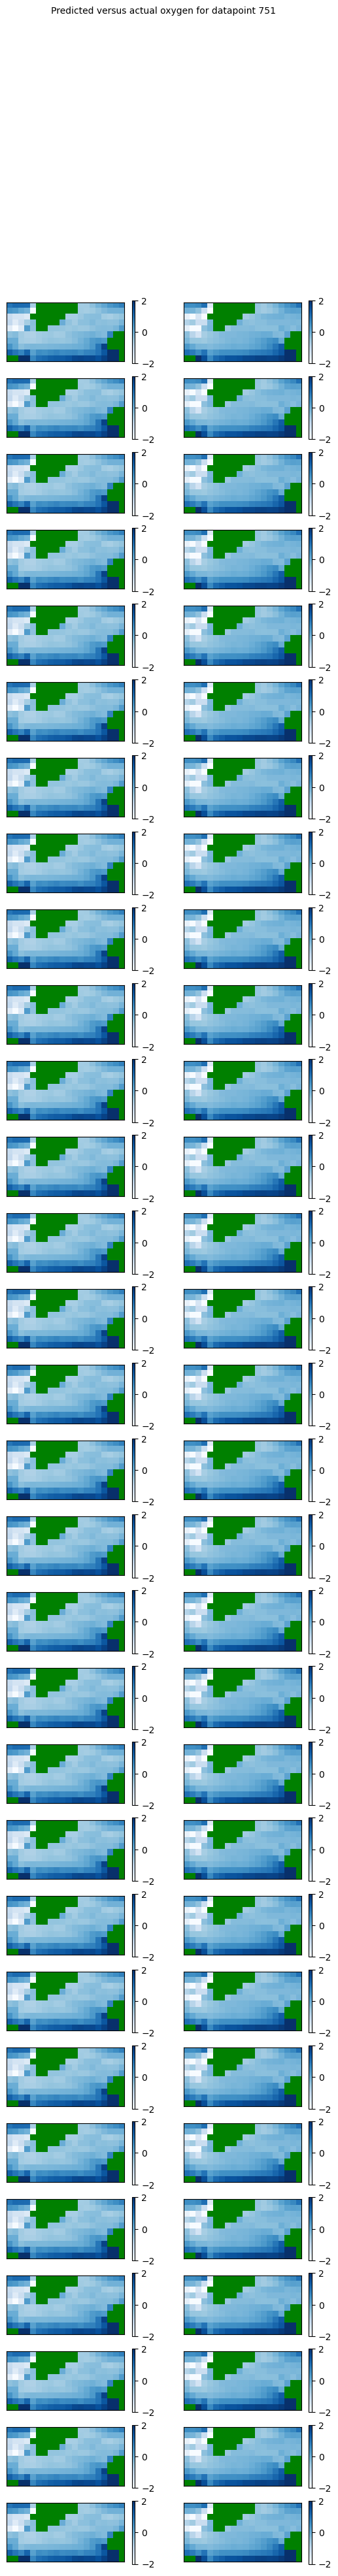

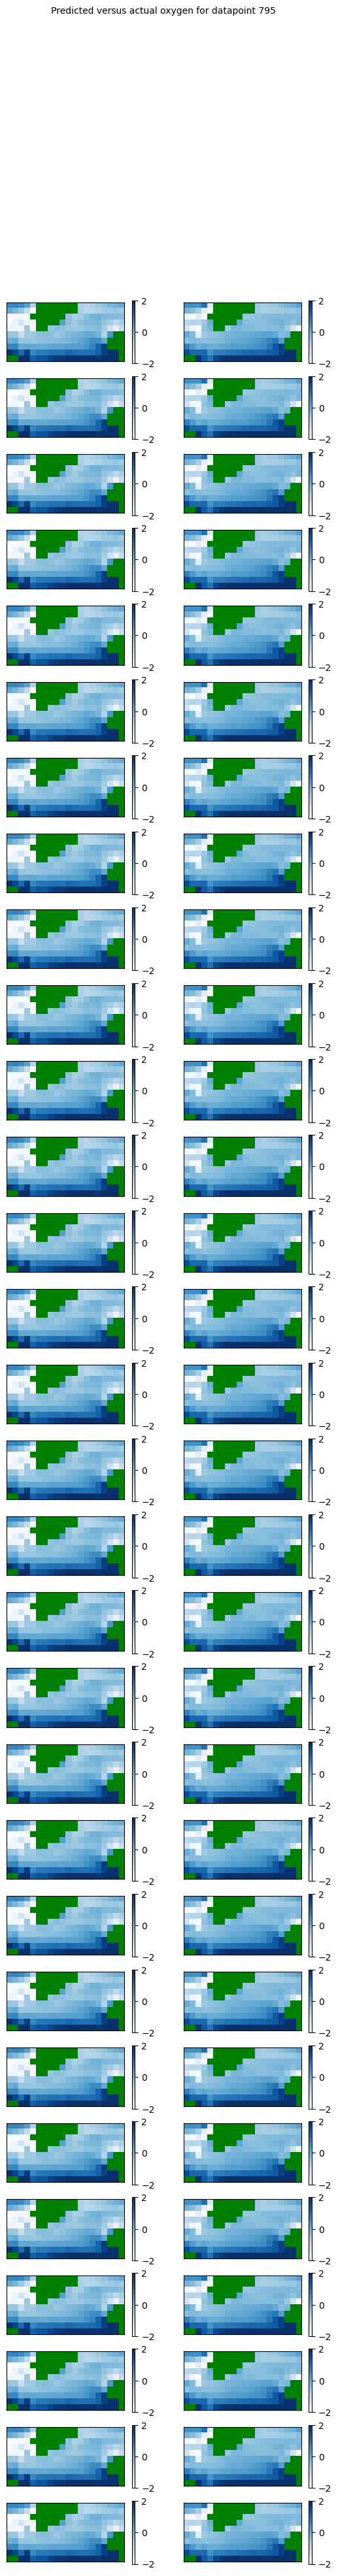

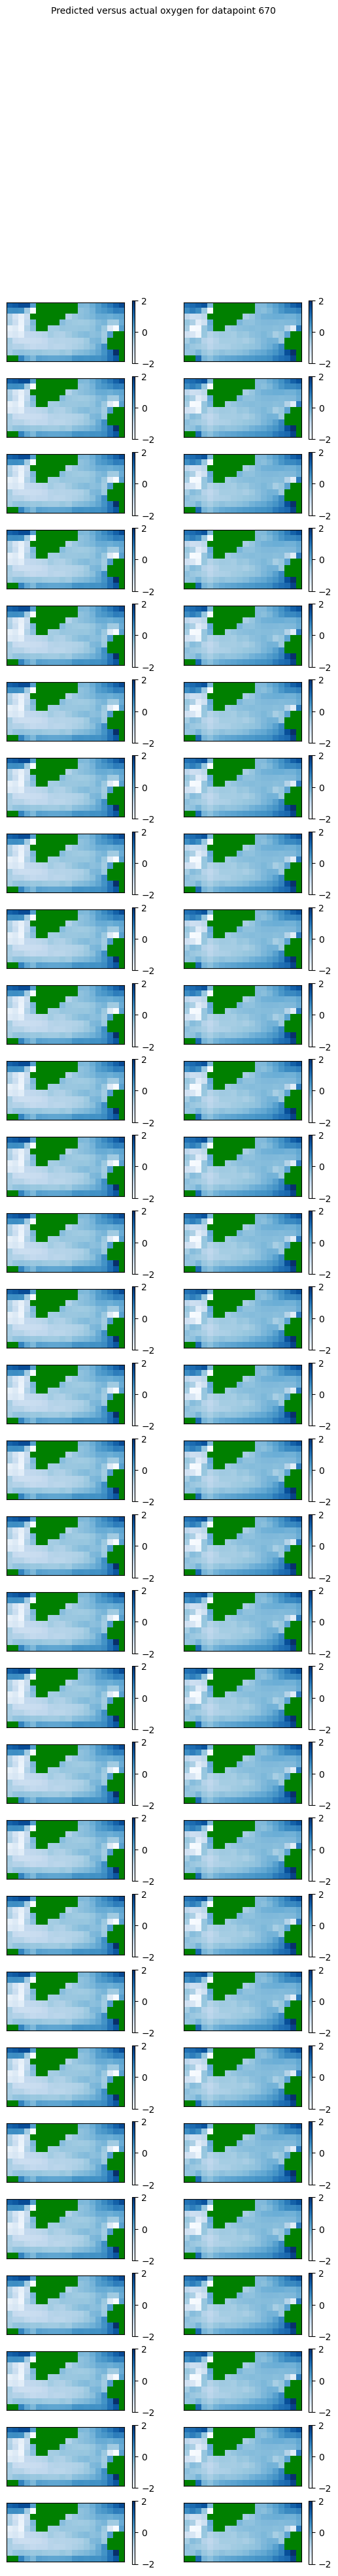

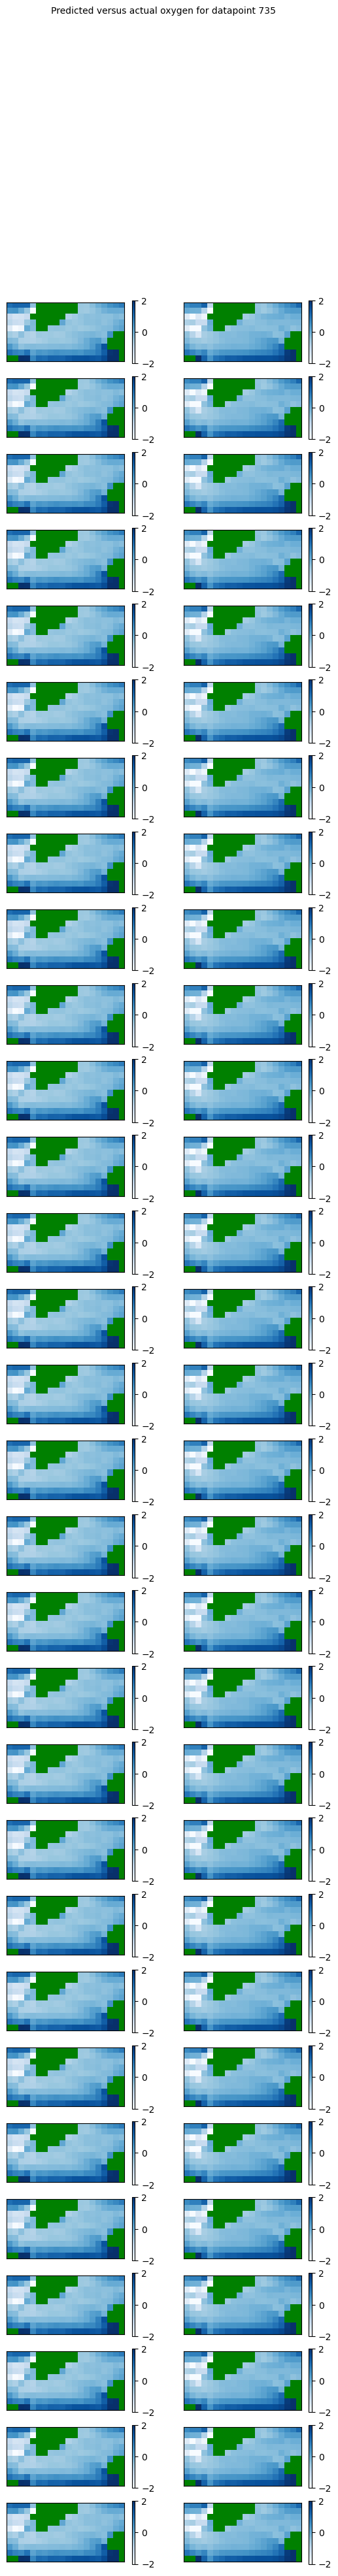

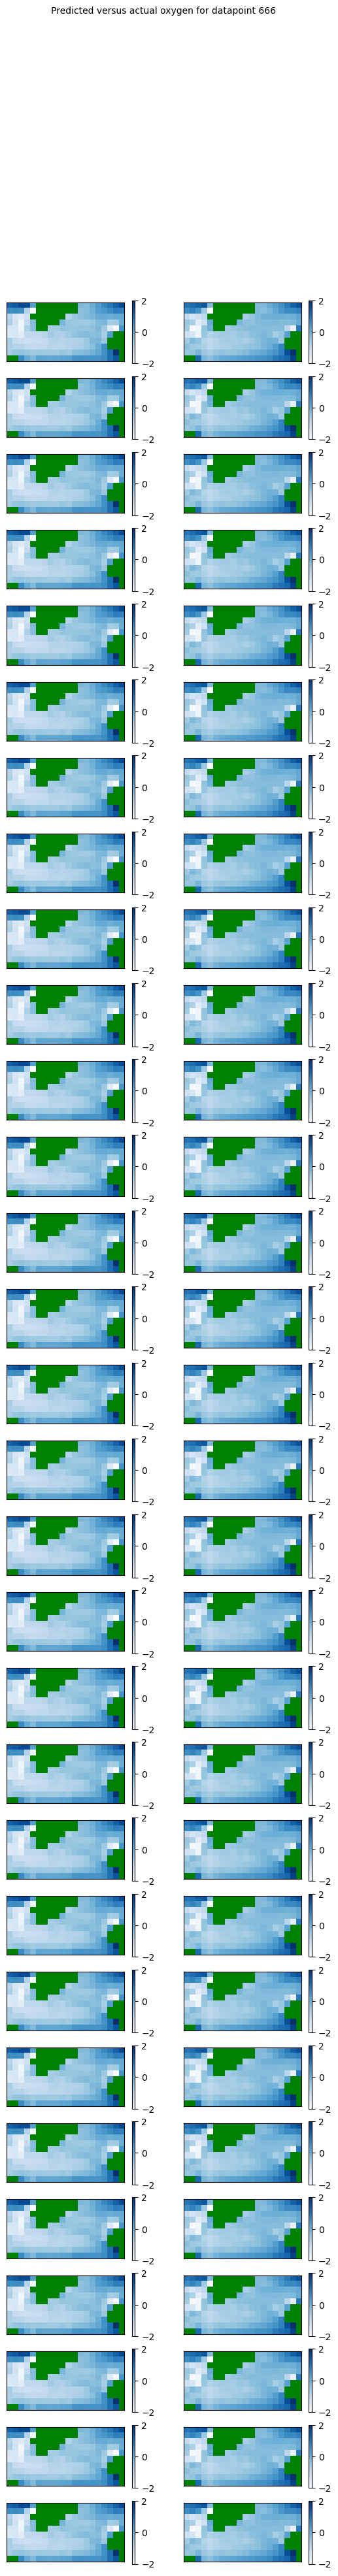

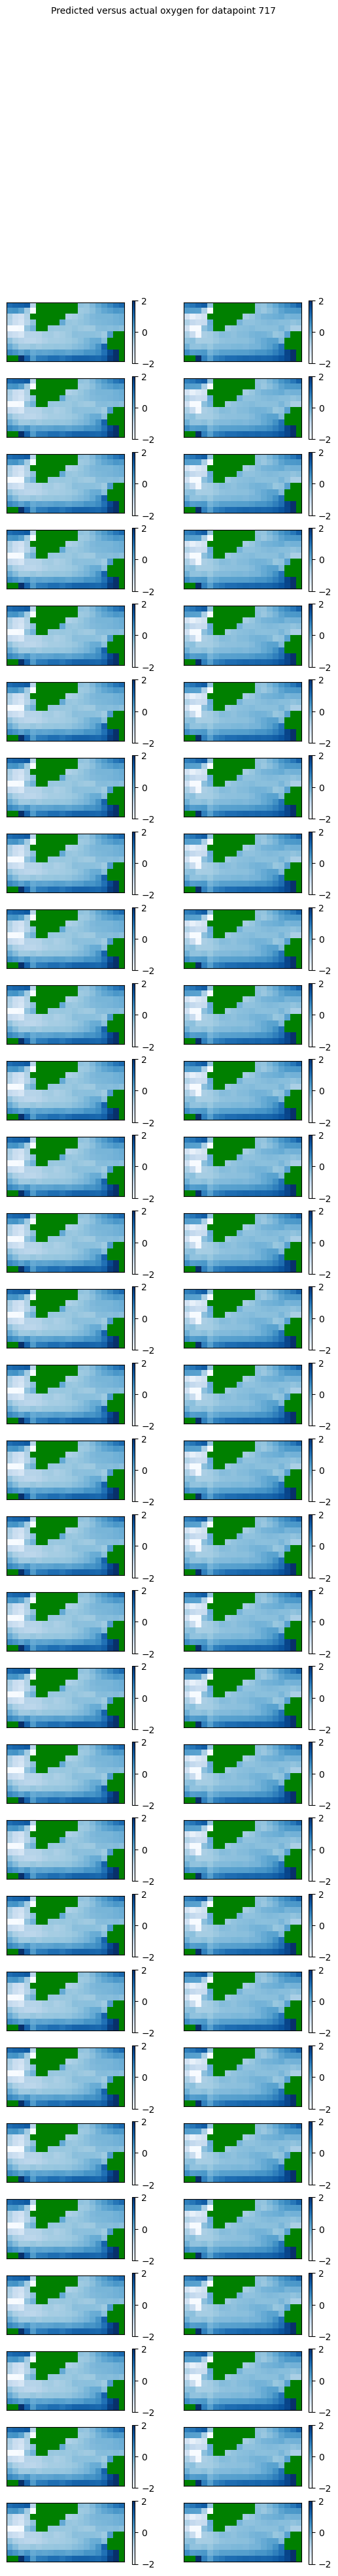

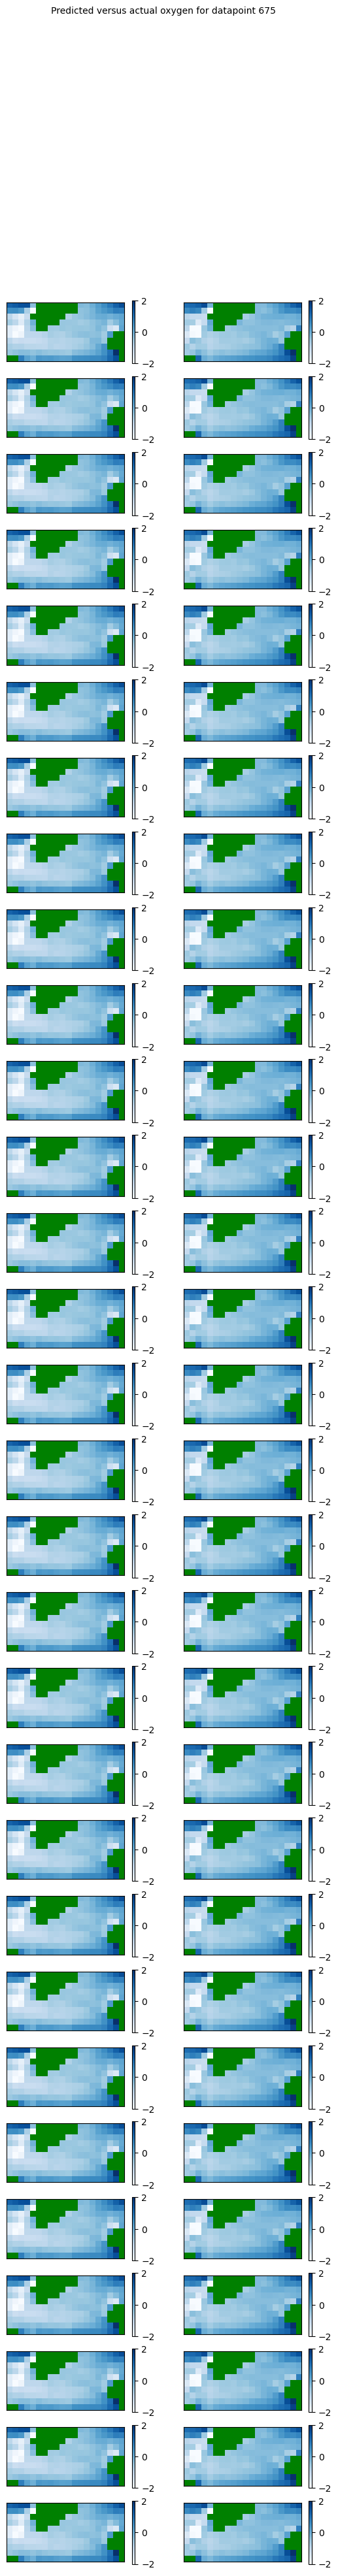

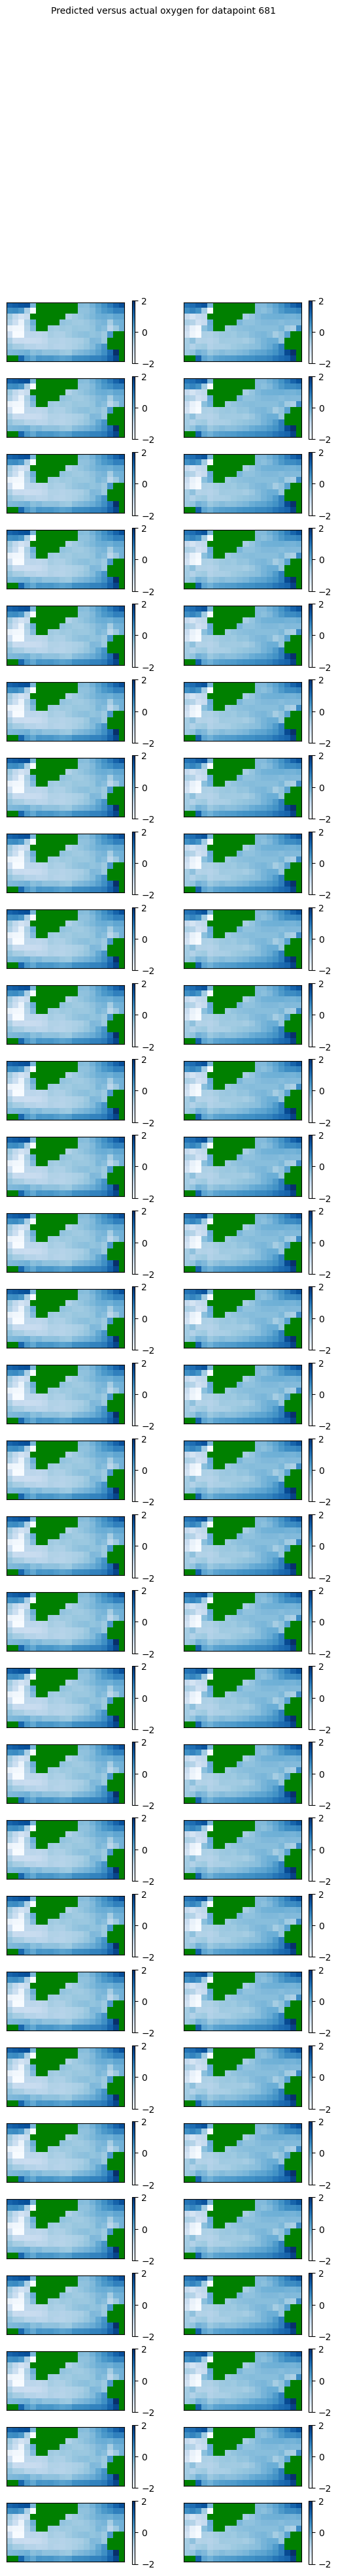

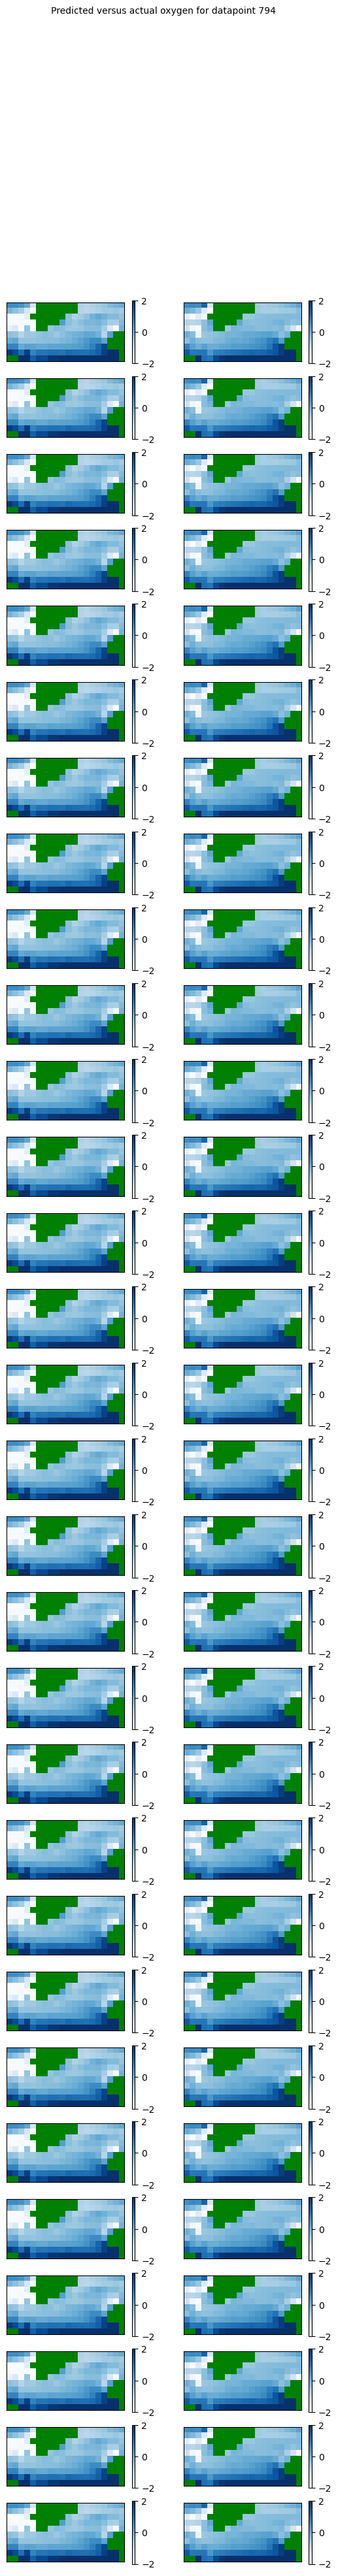

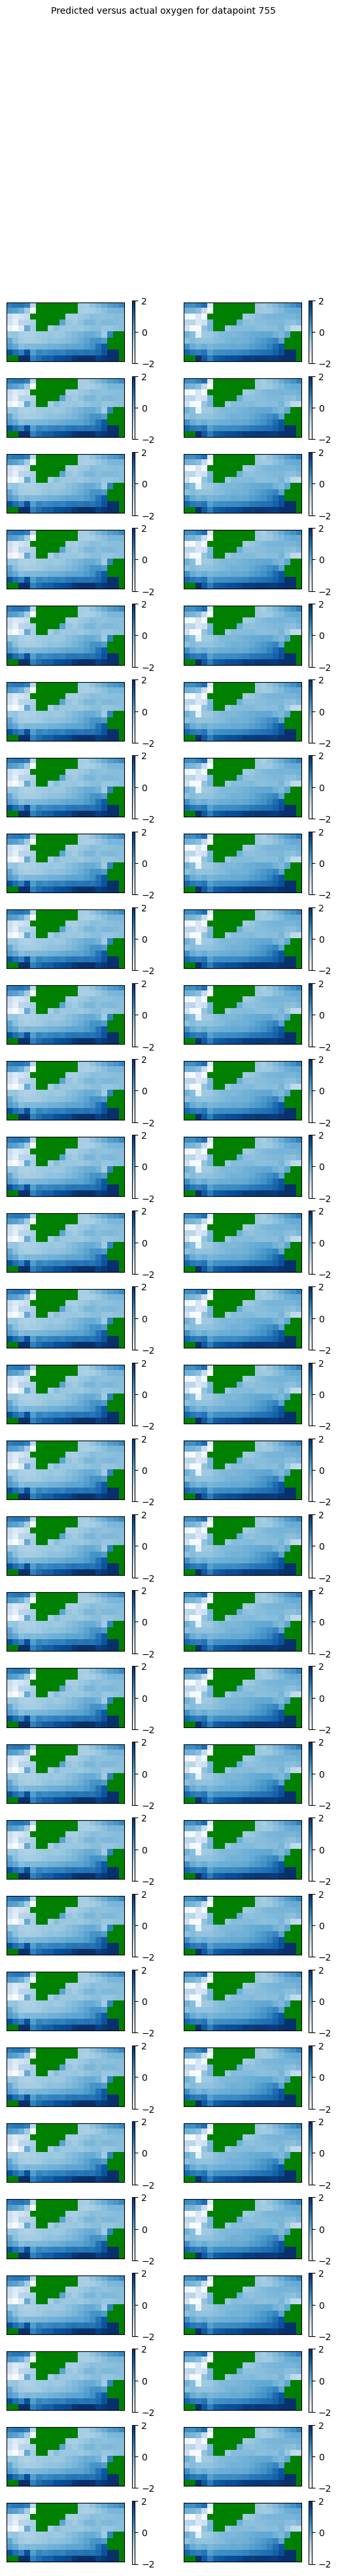

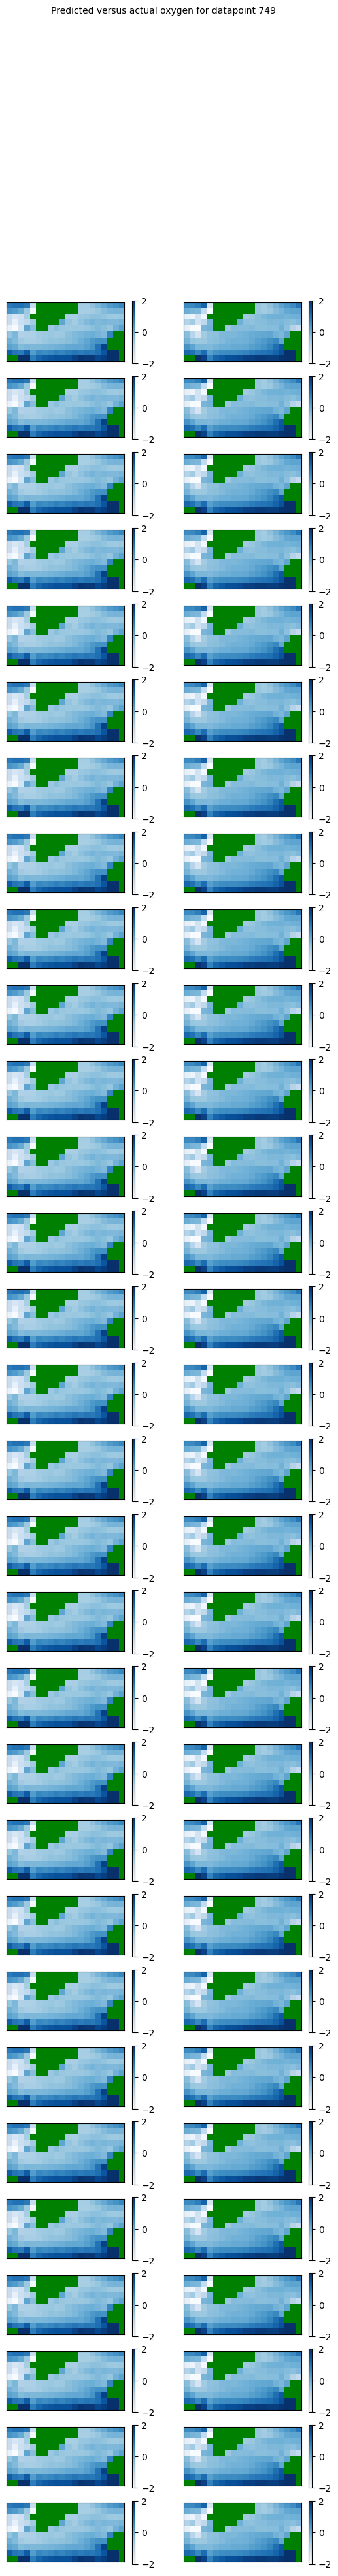

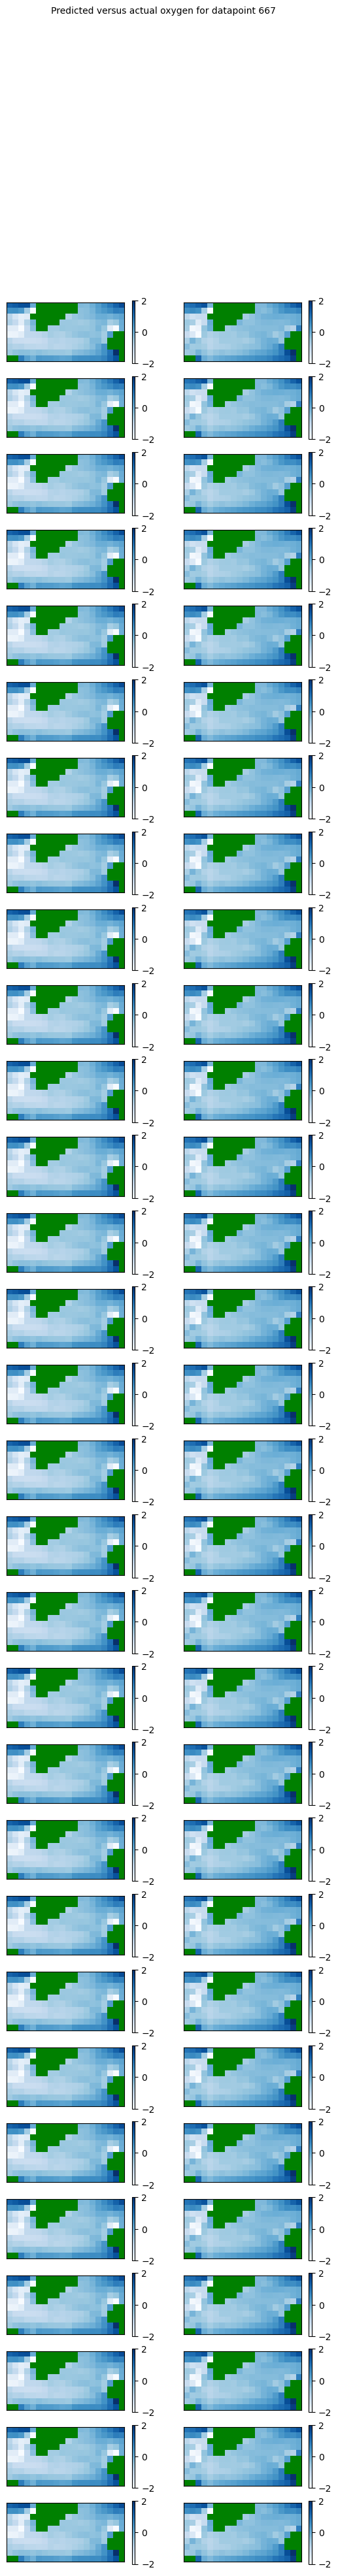

In [209]:
for i, ind in enumerate(sample_indices):
    y_pred_ = y_pred[i, :, 1, :, :]
    y_true_ = y_true[i, :, 1, :, :]

    fig, axes = plt.subplots(30,2)

    fig.set_figheight(45)
    
    fig.suptitle(f'Predicted versus actual oxygen for datapoint {ind}', fontsize=10)
    
    for j in range(30):
        axs = axes[j]
        axs[0].get_xaxis().set_ticks([])
        axs[0].get_yaxis().set_ticks([])
        axs[1].get_xaxis().set_ticks([])
        axs[1].get_yaxis().set_ticks([])
        t = axs[0].imshow(y_true_[i], cmap=cmap, vmin=-2, vmax=2)
        p = axs[1].imshow(y_pred_[i], cmap=cmap, vmin=-2, vmax=2)
        fig.colorbar(t, ax=axs[0], location='right')
        fig.colorbar(p, ax=axs[1], location='right')
    
    plt.savefig(f'graph_point_{ind}.pdf', format='pdf')
    plt.show()